https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V2: outputs variable # of patches according to input

# Setup

In [283]:
import sys
sys.path.append("/Users/ms/cs/ML/SingleImageINR/MedDINOv3/nnUNet")

from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

# import nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer
# from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

In [284]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [285]:
# --- Initialize the ViT backbone ---
model = vit_base(
    drop_path_rate=0.0,
    layerscale_init=1.0e-05,
    n_storage_tokens=4,
    qkv_bias=False,
    mask_k_bias=True,
    pos_embed_rope_dtype="fp32",
    norm_layer="layernormbf16",    
)

# --- Load MedDINOv3 pretrained weights ---
chkpt = torch.load("/home/minsukc/SIO/meddino_model.pth", map_location="cpu")

# If the checkpoint dict contains nested keys, extract the "teacher" weights if needed
if "teacher" in chkpt:
    chkpt = chkpt["teacher"]

# model.load_state_dict(chkpt, strict=True)
# model.to(device).eval()

# print("✅ MedDINOv3 loaded successfully.")

# remove the "backbone." prefix if present
new_chkpt = {}
for k, v in chkpt.items():
    if k.startswith("backbone."):
        new_chkpt[k[len("backbone."):]] = v
    else:
        new_chkpt[k] = v

# load in float32
for k, v in new_chkpt.items():
    new_chkpt[k] = v.float()

model.load_state_dict(new_chkpt, strict=True)
model.to(device, dtype=torch.float32).eval()

print("✅ MedDINOv3 backbone loaded successfully.")

/tmp/ipykernel_734654/2498350318.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load("/home/minsukc/SIO/meddino_model.pth", map_location="cpu")


✅ MedDINOv3 backbone loaded successfully.


In [286]:
# --- Multi-image setup ---
data_dir = "/home/minsukc/SIO/data/"
# target_image_1 = "Chest_X-Ray_1.png"
# target_image_2 = "Chest_X-Ray_1_translated_50_30.png"
# target_image_2 = "Chest_X-Ray_1_translated_100_100.png"
# target_image_1 = "ct_chest_1.jpeg"
# target_image_2 = "ct_chest_1_translated_100_100.jpeg"
# target_image_1 = "ct_chest_2.png"
# target_image_2 = "ct_chest_2_translated_100_100.png"
# target_image_1 = "CT_Slice_3.jpg"
# target_image_2 = "CT_Slice_3_translated_80_80.jpg"
target_image_1 = "CT_Slice_4.png"
target_image_2 = "CT_Slice_4_translated_100_100.png"
# target_image_2 = "ct_chest_2_translated_300_300.png"
# target_image = "ct_abdomen_1.png"

image1 = Image.open(os.path.join(data_dir, target_image_1)).convert("RGB")
image2 = Image.open(os.path.join(data_dir, target_image_2)).convert("RGB")

# Match sizes (important!)
w1, h1 = image1.size
w2, h2 = image2.size
target_h = min(h1, h2)
target_w = min(w1, w2)

image1 = image1.resize((target_w, target_h))
image2 = image2.resize((target_w, target_h))

# 🔹 Concatenate horizontally (side-by-side)
# concat_image = Image.new("RGB", (target_w * 2, target_h))
concat_image = Image.new("RGB", (target_w , target_h*2))
concat_image.paste(image1, (0, 0))
# concat_image.paste(image2, (target_w, 0))
concat_image.paste(image2, (0, target_h))

# or vertically (optional):
# concat_image = Image.new("RGB", (target_w, target_h * 2))
# concat_image.paste(image1, (0, 0))
# concat_image.paste(image2, (0, target_h))

image = concat_image  # use this unified image below

# --- Preprocessing ---
preprocess = transforms.Compose([
    # transforms.Resize((target_h, target_w * 2)),  # keep same preprocessing
    transforms.Resize((target_h*2, target_w)),  # keep same preprocessing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

inputs = preprocess(image).unsqueeze(0).to(device) #type:ignore
print("Input shape:", inputs.shape)

Input shape: torch.Size([1, 3, 1024, 512])


# [CLS] Token Attention Map

In [287]:
# Author's code does not store the raw attention weights → hard to do CLS visualization

In [288]:
# -----------------------------
# CLS → Patch Attention (Capture via Hook)
# -----------------------------
attn_map = {}

def capture_last_attn(module, input, output):
    """
    Extract raw attention weights from the last SelfAttention layer.
    """
    x = input[0]  # [B, N, C]
    B, N, C = x.shape
    qkv = module.qkv(x)
    qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
    q, k, _ = qkv[0], qkv[1], qkv[2]
    attn = (q @ k.transpose(-2, -1)) * module.scale
    attn = attn.softmax(dim=-1)
    attn_map["last"] = attn.detach().cpu()  # shape [B, heads, N, N]

# Register hook on the *last* block's attention
hook_handle = model.blocks[-1].attn.register_forward_hook(capture_last_attn)

with torch.no_grad():
    feats = model.forward_features(inputs)
hook_handle.remove()


patch_feats = feats["x_norm_patchtokens"].squeeze(0)  # type: ignore # [N_patches, D]
cls_feat = feats["x_norm_clstoken"].unsqueeze(0)      # type: ignore # [1, D]

print("patch_feats:", patch_feats.shape)
print("cls_feat:", cls_feat.shape)
print(torch.isnan(feats["x_norm_patchtokens"]).any()) # type: ignore


patch_feats: torch.Size([2048, 768])
cls_feat: torch.Size([1, 1, 768])
tensor(False, device='cuda:0')


In [289]:
print(inputs.shape)
# Average across heads
attn = attn_map["last"].mean(dim=1)[0]  # [N, N]

num_registers = model.n_storage_tokens  # usually 4
cls_to_patches = attn[0, 1 + num_registers:]  # skip CLS + register tokens

# patch_h = patch_w = int(patch_feats.shape[0] ** 0.5)
_, _, H, W = inputs.shape  # e.g. [1, 3, 768, 1536] if concatenated horizontally
patch_size = model.patch_size if hasattr(model, "patch_size") else 16  # typical for ViT
patch_h, patch_w = H // patch_size, W // patch_size
print(f"Patch grid (hxw): {patch_h}x{patch_w}")

cls_to_patches = cls_to_patches.reshape(patch_h, patch_w)
cls_to_patches = (cls_to_patches - cls_to_patches.min()) / (cls_to_patches.max() - cls_to_patches.min() + 1e-8)


torch.Size([1, 3, 1024, 512])
Patch grid (hxw): 64x32


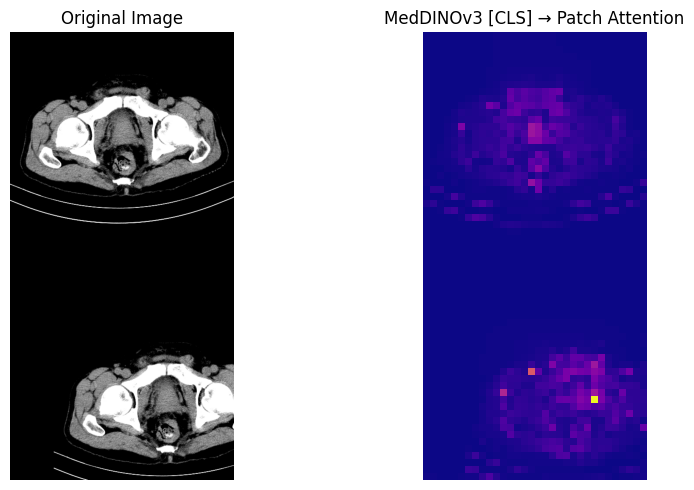

In [290]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cls_to_patches, cmap="plasma", interpolation="nearest")
plt.title("MedDINOv3 [CLS] → Patch Attention")
plt.axis("off")
plt.tight_layout()
plt.show()


# Patch Similarity Map

In [291]:
num_patches = patch_feats.shape[0]
# patch_side = int(num_patches ** 0.5)
patch_h, patch_w = H // patch_size, W // patch_size


# pick a few query patches (grid positions)
grid_size = 4
coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

Queries: 16


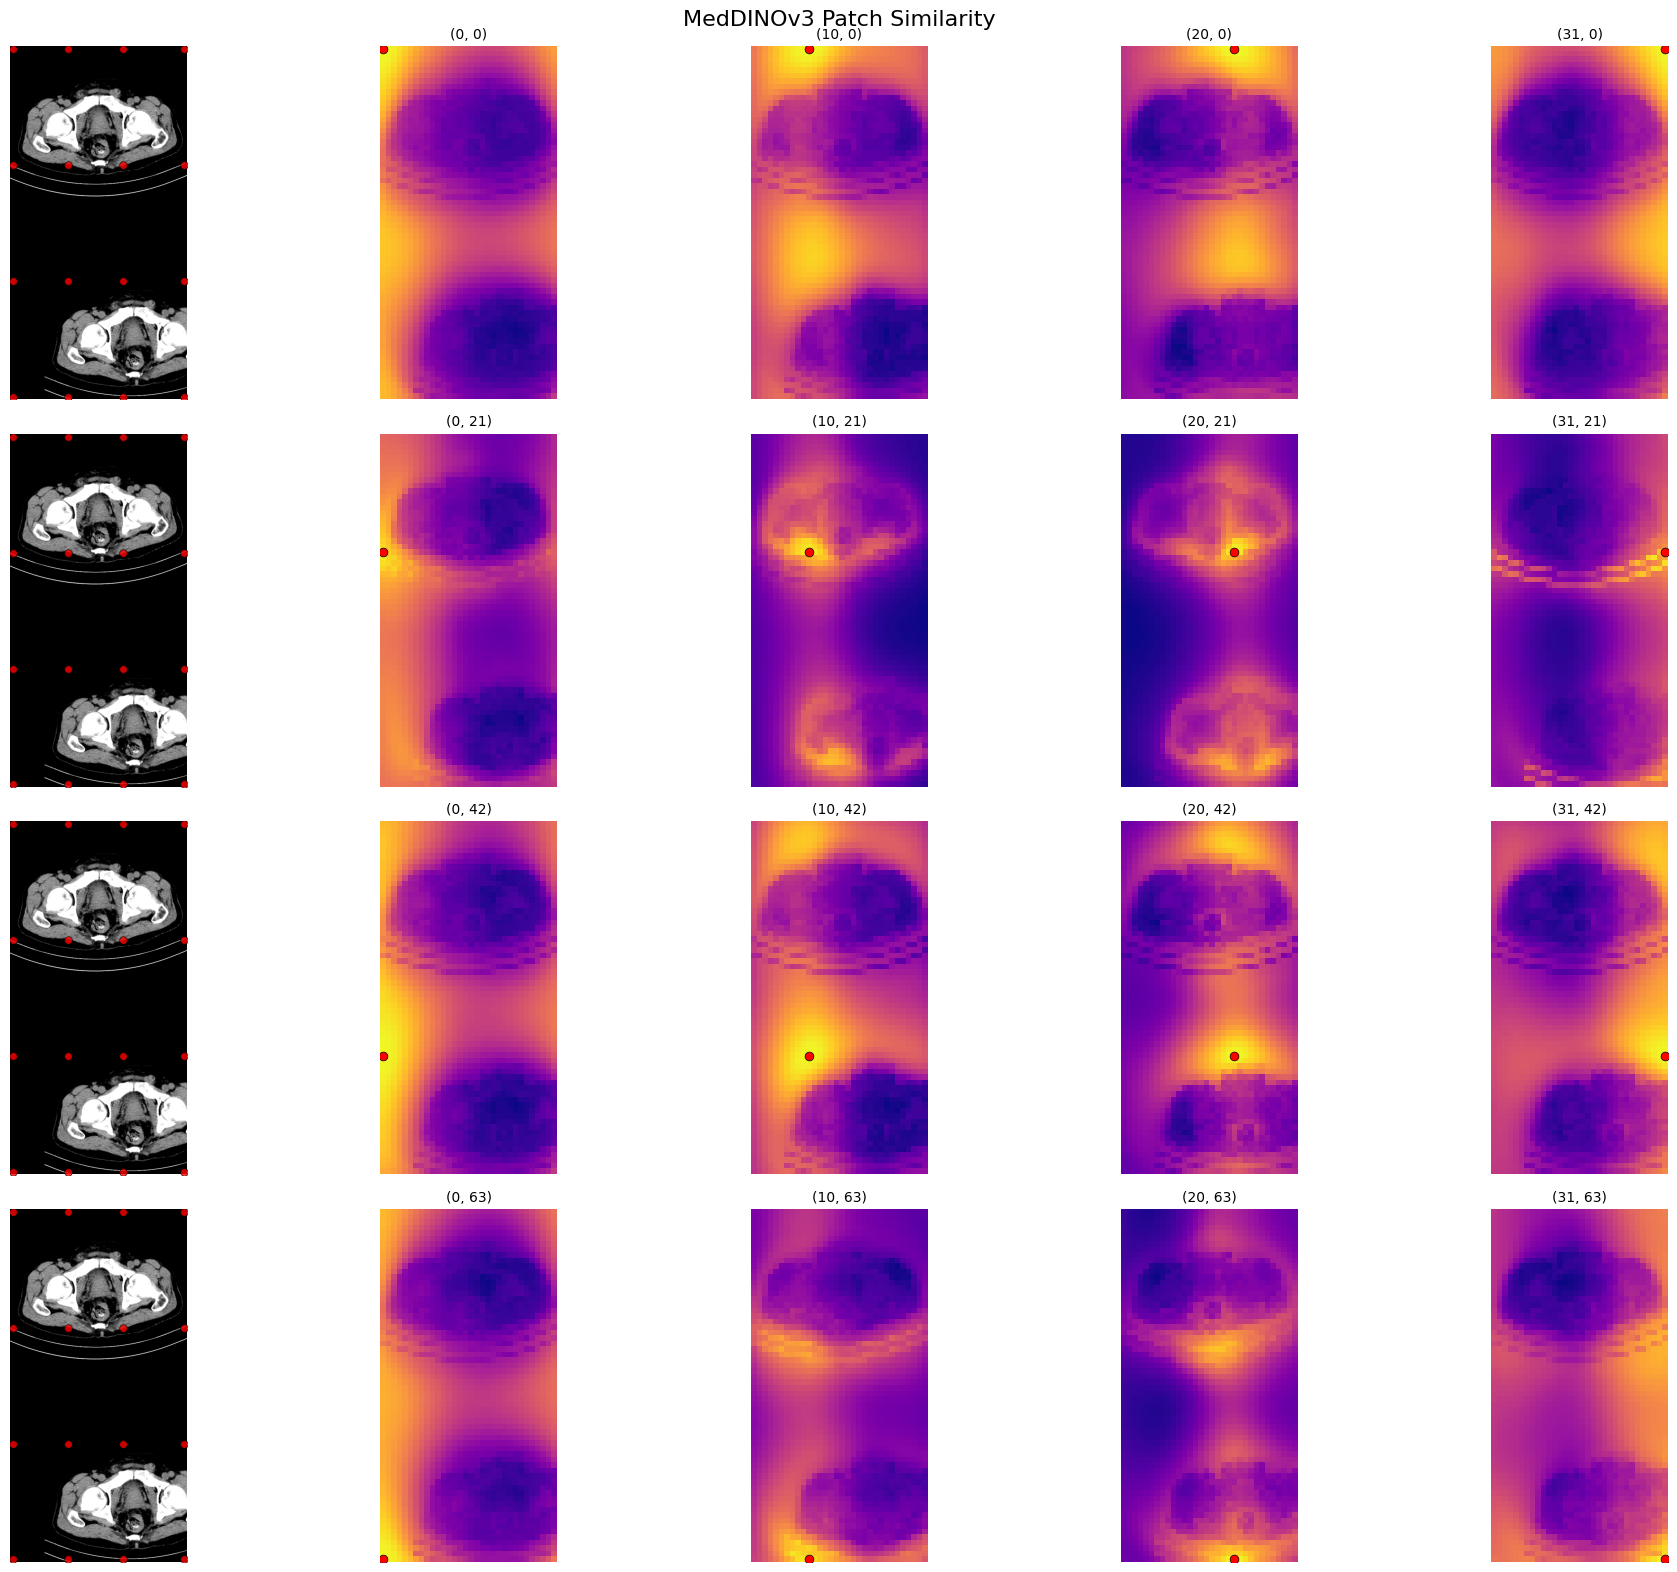

In [292]:
cols, rows = grid_size, grid_size
print(f"Queries: {len(query_indices)}")

# ---- Figure setup ----
fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# ---- Left column: original image ----
for r in range(rows):
    ax_img = axes[r, 0]
    ax_img.imshow(image)
    ax_img.axis("off")

    # mark all query patch centers
    for q_idx in query_indices:
        qy, qx = divmod(q_idx, patch_w)
        img_w, img_h = image.size
        center_x = (qx + 0.5) * (img_w / patch_w)
        center_y = (qy + 0.5) * (img_h / patch_h)
        ax_img.scatter(center_x, center_y,
                       color="red", s=30, marker="o",
                       edgecolors="black", linewidth=0.5, alpha=0.8)

# ---- Right grid: similarity maps ----
ax_list = []
for r in range(rows):
    for c in range(1, cols + 1):
        ax_list.append(axes[r, c] if rows > 1 else axes[c])

for ax, q_idx in zip(ax_list, query_indices):
    query_feat = patch_feats[q_idx:q_idx + 1]
    sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
    sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()  # ✅ correct shape
    sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)

    qy, qx = divmod(q_idx, patch_w)
    ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
    ax.scatter(qx, qy, color="red", s=40, marker="o",
               edgecolors="black", linewidth=0.5)
    ax.set_title(f"({qx}, {qy})", fontsize=10)
    ax.axis("off")

plt.suptitle("MedDINOv3 Patch Similarity", fontsize=16)
plt.tight_layout()
plt.show()

# PCA

In [293]:
from sklearn.decomposition import PCA

feats = patch_feats.cpu().numpy()
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(feats)
pca_feats = (pca_feats - pca_feats.min(0)) / (pca_feats.max(0) - pca_feats.min(0) + 1e-8)

# patch_h, patch_w = H // patch_size, W // patch_size
pca_img = pca_feats.reshape(patch_h, patch_w, 3)

(64, 32, 3)


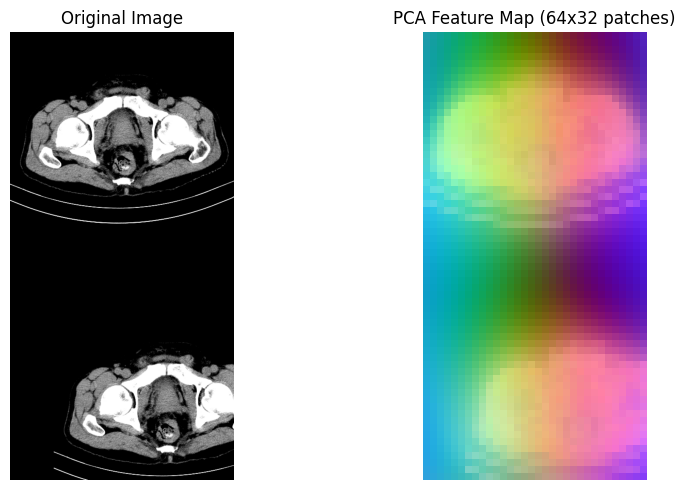

In [294]:
# plt.subplot(1,2,1)
# plt.imshow(image)
# plt.axis("off")
# plt.title("Original")

# plt.subplot(1,2,2)
# plt.imshow(pca_img, interpolation="nearest")
# plt.axis("off")
# plt.title("PCA of Patch Features")
# plt.show()

print(pca_img.shape)
# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(pca_img,interpolation="nearest")
axes[1].set_title(f"PCA Feature Map ({patch_h}x{patch_w} patches)")
axes[1].axis("off")

plt.tight_layout()
plt.show()